# Create a Pseudo-FGS to be read into MAGIC GUI

This notebook can be used to create a pseudo-FGS image and by-pass the convert image section of the MAGIC GUI in order to access more options (like hand-selecting the smoothing to more accurately find more stars). The image and files will be saved out and can be re-accessed in the MAGIC GUI in order to run the other steps by typing in the root and out directory.

### Imports

In [1]:
import logging
import os
import shutil
import sys

from astropy.io import fits
from astropy.io import ascii as asc
import fgscountrate
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from PyQt5.QtWidgets import QApplication, QDialog
from PyQt5.QtCore import QCoreApplication

import jwst_magic
from jwst_magic.convert_image import background_stars, convert_image_to_raw_fgs, renormalize, background_stars_GUI
from jwst_magic.fsw_file_writer import buildfgssteps, write_files
from jwst_magic.star_selector import select_psfs
from jwst_magic.utils import utils
PACKAGE_PATH = jwst_magic.__file__.split('jwst_magic/__init__.py')[0]

LOGGER = logging.getLogger('create-pseudo-fgs-notebook')

%matplotlib inline

Using backend:  Qt5Agg
Your MAGIC package is up to date
Your FGS COUNTRATE package is up to date


### Set basic input values - User should change these values

In [2]:
# Input image and paths
image = '/Users/sosborne/Desktop/MAGIC/input_images/jw01158002001_02101_00001_nrca3_cal.fits'  # path to input image
guider = 1
root = 'test-case1'
out_dir = '/Users/sosborne/Desktop/MAGIC/test/'


# Detector information
nircam = True  # True if NIRCam image, False if FGS image
nircam_det = 'NRCA3'  # string for NIRCam detector, None for FGS image


# Normalization information
normalize = True  # True if you want to renormalize the image
norm_unit = "FGS Magnitude"  # "FGS Magnitude", "FGS countrate", or "Guide Star ID"
norm_value = 12  # Value for the corresponding norm unit
itm = False  # True if the input image is from ITM
npeaks = None # Set to a specific number if you want MAGIC to only find that many PSFs (this will find the brightest) 

add_background_stars = True  # Whether to add background stars

### Add background stars

The user doesn't need to change anything in this code, just run it.

If add_background_stars is set to True above, the background stars GUI will open and it should be filled out like normal.

In [3]:
if add_background_stars:
    
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    
    bkgrdstars_hdr = {}
    
    if normalize:
        fgs_countrate, fgs_mag = renormalize.convert_to_countrate_fgsmag(norm_value, norm_unit, guider)
    # If not, determine the FGS counts of the input image
    else:
        data, _ = utils.get_data_and_header(image)
        fgs_countrate = np.sum(data[data > np.median(data)])
        fgs_mag = fgscountrate.convert_cr_to_fgs_mag(fgs_countrate, guider)
    

    _bkgdstars_dialog = background_stars_GUI.BackgroundStarsDialog(guider, fgs_mag,
                                                                    out_dir=out_dir, root=root,
                                                                    in_main_GUI=False)
    accepted = _bkgdstars_dialog.exec()
    bkgd_stars = _bkgdstars_dialog.return_dict() if accepted else None

    if bkgd_stars is None:
        if accepted:
            raise ValueError('Background Stars GUI missing information. No background stars selected')
        else: 
            bkgrd_image = os.path.join(out_dir, 'out', root, 'background_stars_{}_G{}.png'.format(root, guider))
            if os.path.exists(bkgrd_image):
                os.remove(bkgrd_image)
            raise ValueError('Background Stars GUI closed. No background stars selected')

    # Record the method used to generate the background stars and populate the main GUI with that
    method = _bkgdstars_dialog.method
    method_adverb = {'random': 'randomly',
                     'user-defined': 'as defined by the user',
                     'catalog': 'from a GSC query'}

    bkgrdstars_hdr['BACKMETH'] = (method, 'Method used to add background stars')
    if method == 'catalog':
        bkgrdstars_hdr['BACK_RA'] = (_bkgdstars_dialog.ra_gs, 'RA from background stars gui')
        bkgrdstars_hdr['BACK_DEC'] = (_bkgdstars_dialog.dec_gs, 'DEC from background stars gui')
        bkgrdstars_hdr['BACK_PA'] = (_bkgdstars_dialog.position_angle, 'V3PA from background stars gui')

else:
    bkgd_stars = False
    bkgrdstars_hdr = None

2021-12-01 14:28:02,202 - stpipe - WARNING - Background Stars: No guide star found within 1 arcsec of the pointing.


### Check input file

In [4]:
fits.info(image)

Filename: /Users/sosborne/Desktop/MAGIC/input_images/jw01158002001_02101_00001_nrca3_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [17275B]   


In [5]:
image_data = fits.getdata(image, ext=1)  # You may have to change the extension

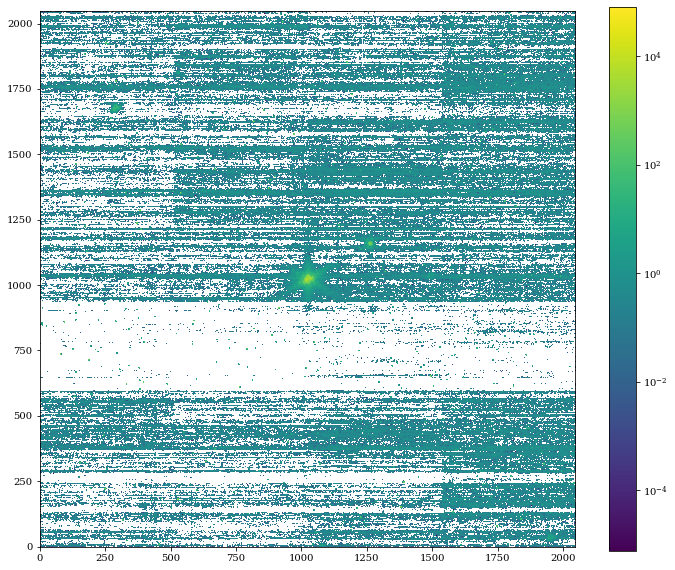

In [6]:
# Plot the input image
plt.figure(figsize=(12, 10))
plt.imshow(image_data, norm=LogNorm(), origin='lower') 
plt.colorbar()
plt.show()

-----

### Set parameters that will affect the star identification

The `smoothing`, `psf_size`, and `detection_threshold` parameters are key to making sure the code finds only the guide star PSF(s) in the imput image.

- The `smoothing` parameter defines how the PSFs are smoothed in order to find the correct number of PSFs in the image. Higher smoothing tends to help when multiple points are found within a single PSF and when bad pixels are found. The parameter can be a string or a float and has the following options:
    1. "high" for large smoothing (e.g. Global Alignment)
    2. "default" for medium smoothing 
    3. a float with the value to use as the sigma value in ndimage.gaussian_filter. For context, "high" smoothing has a sigma=26 and "default" smoothing has a sigma=5.


- The `psf_size` parameter defines the size of the box in pixels that is used to cut out the PSFs. This can be set to any float value, but it usually set to 100 pixels for non-GA PSFs and 150 for GA PSFs



- The `detection_threshold` parameter sets the threshold for the image above which stars are identified. The parameeter is a string and has 2 options for how it can be set:
    1. "standard-deviation" to set threshold=median + (3 * std) 
        - This is useful mostly for commissioning scenarios
    2. "pixel-wise" to use photutils' detect_threshold() function 
        - useful mostly for normal operations

In [7]:
# Play around with the values in this cell until you get a pseudo-FGS image you like.

# Set smoothing parameter
smoothing = 15

# Set PSF size
psf_size = 100

# Set detection threshold parameters
detection_threshold = 'standard-deviation'

### Run code

You may get red highlighted warnings from the JWST Pipeline (they will say "stpipe.ResampleStep"). You can feel free to ignore those, they are expected.

In [8]:
# Determine filename root
root = utils.make_root(root, image)

# Determine output directory
out_dir_root = utils.make_out_dir(out_dir, PACKAGE_PATH, root)
utils.ensure_dir_exists(out_dir_root)

# Set up logging
_, log_filename = utils.create_logger_from_yaml(__name__, out_dir_root=out_dir_root, root=root, level='DEBUG')

LOGGER.info("Package directory: {}".format(PACKAGE_PATH))
LOGGER.info("Processing request for {}.".format(root))
LOGGER.info("All data will be saved in: {}".format(out_dir_root))
LOGGER.info("Input image: {}".format(os.path.abspath(image)))

# Copy input image into out directory
try:
    shutil.copy(os.path.abspath(image), out_dir_root)
except shutil.SameFileError:
    pass

# Either convert provided NIRCam image to an FGS image...
fgs_im, all_found_psfs_file, psf_center_file, fgs_hdr_dict = \
    convert_image_to_raw_fgs.convert_im(image, guider, root,
                                        out_dir=out_dir,
                                        nircam=nircam,
                                        nircam_det=nircam_det,
                                        normalize=normalize,
                                        norm_value=norm_value,
                                        norm_unit=norm_unit,
                                        smoothing=smoothing,
                                        detection_threshold=detection_threshold,
                                        psf_size=psf_size,
                                        coarse_pointing=False,
                                        jitter_rate_arcsec=None,
                                        logger_passed=True,
                                        itm=itm,
                                        num_peaks=npeaks)

# Add logging information to fgs image header
fgs_hdr_dict['LOG_FILE'] = (os.path.basename(log_filename), 'Log filename')

if bkgd_stars:
    if not normalize and not itm:
        norm_value = np.sum(fgs_im[fgs_im > np.median(fgs_im)])
        norm_unit = "FGS Counts"
    fgs_im = background_stars.add_background_stars(fgs_im, bkgd_stars,
                                                   norm_value, norm_unit,
                                                   guider, save_file=True,
                                                   root=root, out_dir=out_dir)
    for key, value in bkgrdstars_hdr.items():
        fgs_hdr_dict[key] = value

# Write converted image
convert_image_to_raw_fgs.write_fgs_im(fgs_im, out_dir, root, guider, fgs_hdr_dict)
LOGGER.info("*** Image Conversion COMPLETE ***")


2021-12-01 14:29:13,070 - INFO - Started logging to file /Users/sosborne/Desktop/MAGIC/test/out/test-case1/2021_12_01_Wed_142913_main_test-case1.log
2021-12-01 14:29:13,071 - INFO - Package directory: /Users/sosborne/repos/jwst_magic/
2021-12-01 14:29:13,072 - INFO - Processing request for test-case1.
2021-12-01 14:29:13,072 - INFO - All data will be saved in: /Users/sosborne/Desktop/MAGIC/test/out/test-case1
2021-12-01 14:29:13,073 - INFO - Input image: /Users/sosborne/Desktop/MAGIC/input_images/jw01158002001_02101_00001_nrca3_cal.fits
2021-12-01 14:29:13,209 - INFO - Image Conversion: Beginning image conversion to guider 1 FGS image
2021-12-01 14:29:13,211 - INFO - Image Conversion: Input image is expected to be in units of ADU/sec (countrate)
2021-12-01 14:29:27,784 - INFO - Image Conversion: Bad pixels removed from image using DQ array from image.
2021-12-01 14:29:27,785 - INFO - Image Conversion: Removing distortion from data using the JWST Pipeline's Resample step.


2021-12-01 14:29:29,545 - stpipe.ResampleStep - INFO - ResampleStep instance created.


2021-12-01 14:29:29,545 - INFO - ResampleStep instance created.


2021-12-01 14:29:29,633 - stpipe.ResampleStep - INFO - Step ResampleStep running with args (<ImageModel(2048, 2048) from jw01158002001_02101_00001_nrca3_cal.fits>,).


2021-12-01 14:29:29,633 - INFO - Step ResampleStep running with args (<ImageModel(2048, 2048) from jw01158002001_02101_00001_nrca3_cal.fits>,).


2021-12-01 14:29:29,637 - stpipe.ResampleStep - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-12-01 14:29:29,637 - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-12-01 14:29:29,676 - stpipe.ResampleStep - INFO - Drizpars reference file: /Users/sosborne/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits


2021-12-01 14:29:29,676 - INFO - Drizpars reference file: /Users/sosborne/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits
2021-12-01 14:29:29,688 - DEBUG - No ASDF information found. Cannot skip updating from FITS headers.
2021-12-01 14:29:29,704 - DEBUG -    good_bits=~DO_NOT_USE+NON_SCIENCE
2021-12-01 14:29:29,705 - DEBUG -    single=False
2021-12-01 14:29:29,706 - DEBUG -    blendheaders=False
2021-12-01 14:29:29,707 - DEBUG -    pixfrac=1.0
2021-12-01 14:29:29,708 - DEBUG -    kernel=square
2021-12-01 14:29:29,708 - DEBUG -    fillval=INDEF
2021-12-01 14:29:29,709 - DEBUG -    pscale_ratio=1.0
2021-12-01 14:29:29,710 - DEBUG -    weight_type=exptime
2021-12-01 14:29:29,760 - DEBUG - Output mosaic size: (2064, 2058)
2021-12-01 14:29:30,117 - DEBUG - Bounding box from data shape: ((-0.5, 2047.5), (-0.5, 2047.5))
2021-12-01 14:29:32,544 - DEBUG - Pixmap shape: (2048, 2048)
2021-12-01 14:29:32,545 - DEBUG - Input Sci shape: (2048, 2048)
2021-12-01 14:29:32,545 - DEBUG 

2021-12-01 14:29:34,352 - stpipe.ResampleStep - INFO - Step ResampleStep done


2021-12-01 14:29:34,352 - INFO - Step ResampleStep done
2021-12-01 14:29:34,354 - INFO - Image Conversion: Cutting undistorted data from (2064, 2058) to (2048, 2048)
2021-12-01 14:29:34,359 - INFO - Image Conversion: Input is a Cal image. Converting from MJy/sr to ADU/s
2021-12-01 14:29:34,360 - INFO - Image Conversion: Skipping removing pedestal - Reference pixel correction run in pipeline.
2021-12-01 14:29:34,361 - INFO - Image Conversion: This is a NIRCam image
2021-12-01 14:29:34,362 - INFO - Image Conversion: Transforming from NIRCAM Detector = NRCA3
2021-12-01 14:29:34,363 - INFO - Image Conversion: Input NIRCam image in SCI coordinate frame.
2021-12-01 14:29:35,553 - INFO - Image Conversion: 2 PSFs detected in Gaussian-smoothed data (threshold = 0.464757809832888; sigma = 15)
2021-12-01 14:29:36,429 - INFO - Image Conversion: Normalizing to 5944707.138896478 FGS Countrate (FGS Mag: 12)
2021-12-01 14:29:37,312 - INFO - Image Conversion: 2 PSFs detected in Gaussian-smoothed data (

2021-12-01 14:29:38,190 - INFO - Background Stars: Adding background star N13I051676 with magnitude 19.9 at location (1006.7870716384571, 23.425876507066505).
2021-12-01 14:29:38,208 - INFO - Background Stars: Adding background star N13I066457 with magnitude 19.9 at location (122.68701562515344, 1463.7264222968556).
2021-12-01 14:29:38,226 - INFO - Background Stars: Adding background star N13I051677 with magnitude 19.8 at location (1386.7607665569321, 74.40736543094476).
2021-12-01 14:29:38,244 - INFO - Background Stars: Adding background star N13I051788 with magnitude 20.4 at location (1629.2986986239425, 1784.4464331665072).
2021-12-01 14:29:38,263 - INFO - Background Stars: Adding background star N13I050431 with magnitude 19.6 at location (1842.7390364956682, 428.68153157103734).
2021-12-01 14:29:38,280 - INFO - Background Stars: Adding background star N13I050343 with magnitude 18.6 at location (729.7172400649413, 2012.3599093778498).
2021-12-01 14:29:38,297 - INFO - Background Star

### Check output files

In [9]:
# Check the path has the right data files
full_out_path = os.path.join(out_dir, 'out', root)
pseudo_fgs_path = os.path.join(full_out_path, 'FGS_imgs', f'unshifted_{root}_G{guider}.fits')
all_found_psfs_path = os.path.join(full_out_path, f'unshifted_all_found_psfs_{root}_G{guider}.txt')
psf_center_path = os.path.join(full_out_path, f'unshifted_psf_center_{root}_G{guider}.txt')
background_stars_path = os.path.join(full_out_path, f'unshifted_background_psfs_{root}_G{guider}.txt')

assert os.path.exists(pseudo_fgs_path)
assert os.path.exists(all_found_psfs_path)
if bkgd_stars is not False:
    assert os.path.exists(background_stars_path)
if smoothing == 'low':
    assert os.path.exists(psf_center_path)


2021-12-01 14:29:38,622 - WARNING - /Users/sosborne/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



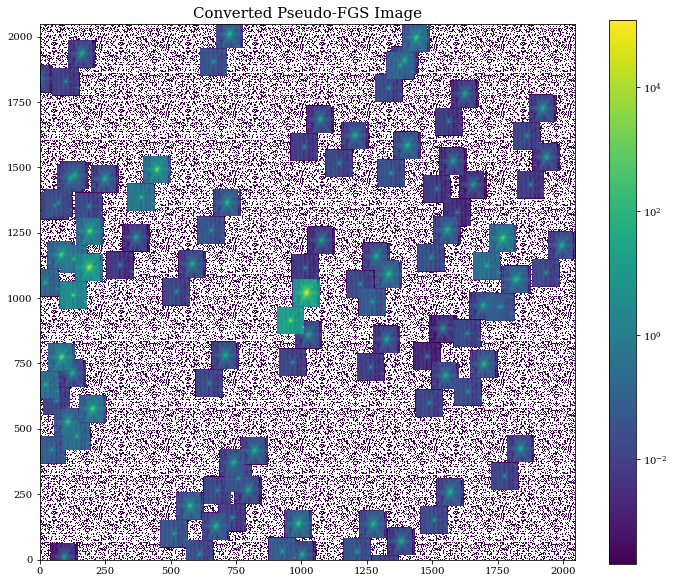

In [10]:
# Plot the converted pseudo-FGS image
output_data = fits.getdata(pseudo_fgs_path, ext=1)
plt.figure(figsize=(12, 10))
plt.imshow(output_data, norm=LogNorm(), origin='lower') 
plt.colorbar()
plt.title('Converted Pseudo-FGS Image', size=15)
plt.show()

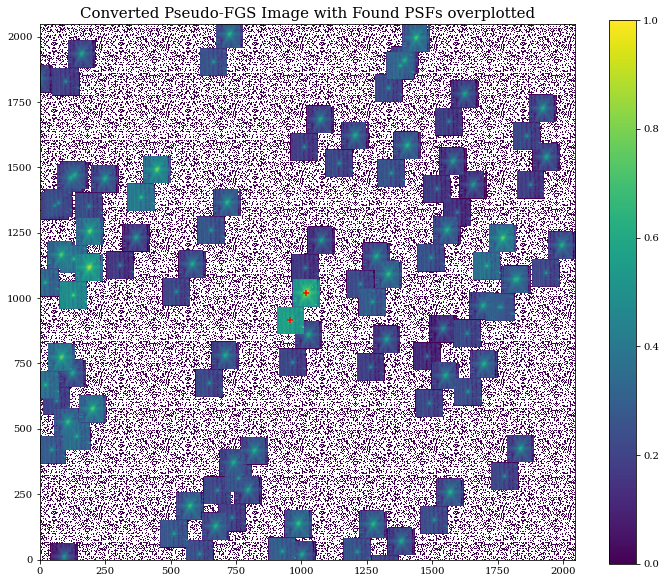

In [11]:
# Plot the converted pseudo-FGS image with identified PSFs
output_data = fits.getdata(pseudo_fgs_path, ext=1)
all_found_psfs = asc.read(all_found_psfs_path)
x = all_found_psfs['x']
y = all_found_psfs['y']


plt.figure(figsize=(12, 10))
plt.imshow(output_data, norm=LogNorm(), origin='lower') 
plt.scatter(x, y, c='r', marker='+')

plt.colorbar()
plt.title('Converted Pseudo-FGS Image with Found PSFs overplotted', size=15)
plt.show()

### Now what?

- If the above image looks good (IE - only the guide star segments one red plus signs over each of them), you are ready to go back to the MAGIC GUI

- If the image doesn't look good, go back up to the "Set parameters that will affect the star identification" cell and update the parameters and re-run the code. Iterate until you are happy with the output image.

------

## Now back in the MAGIC GUI:
 - Open the GUI
 - Get into manual naming
 - Enter in the input image, guider, root, and out directory information from above
 - Confirm the the GUI recognizes that the Image Conversion section has already been completed for this root, and grays-out that portion of the GUI. 
 - Check the red plus signs in the Converted FGS Image in the Image Preview section of the GUI. Are the right PSFs found?
 - Fill out the star selection and FSW Writer parts of the GUI
 - Click Run